
# Keyword spotting



We first import all the necessary modules

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

We check if CUDA is available and if it's the case then all our calculus will be way faster


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use the dataset SPEECHCOMMANDS from PyTorch

We also create our train and test sets, validation and testing sets have been predefined with txt files and training set is everything minus the train and test sets



In [66]:
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torch
import numpy as np

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./SpeechCommandsRAW", download=False)
        
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

keywords = ['yes','stop','down','up','right','left','on','off']
unknown_label = 'unknown'
silence_label = 'silence'

# Create training and testing split of the data.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

def label_transform(label):
    if label in keywords:
        return label
    elif label == 'silence':
        return silence_label
    else:
        return unknown_label



def create_silence_samples(noise_dir, num_samples=1000, sample_length=16000, sample_rate=16000):
    def load_noise_files(noise_dir):
        noise_files = []
        for file_name in os.listdir(noise_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(noise_dir, file_name)
                noise, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    noise = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)(noise)
                noise_files.append(noise)
        return noise_files

    noise_files = load_noise_files(noise_dir)
    silence_samples = []

    for _ in range(num_samples):
        noise = noise_files[np.random.randint(0, len(noise_files))][0]
        if noise.ndim == 1:
            noise = noise.unsqueeze(0)
        if noise.size(1) > sample_length:
            start = np.random.randint(0, noise.size(1) - sample_length)
            noise = noise[:, start:start+sample_length]
        elif noise.size(1) < sample_length:
            noise = torch.cat([noise, torch.zeros(1, sample_length - noise.size(1))], dim=1)
        
        amplitude = np.random.uniform(0.1, 0.4)
        noise = noise / noise.abs().max() * amplitude  # Normalize and adjust amplitude
        silence_samples.append((noise, sample_rate, silence_label, 'silence_speaker', 0))

    return silence_samples

def filter_and_balance_data(dataset, keywords, unknown_label, silence_samples_ratio=0.5):
    keyword_samples = []
    unknown_samples = []

    for sample in dataset:
        label = label_transform(sample[2])
        if label in keywords:
            keyword_samples.append(sample)
        elif label == unknown_label:
            unknown_samples.append(sample)

    # Subsample unknown samples to achieve the desired ratio
    num_unknown_samples = int(len(keyword_samples) * silence_samples_ratio)
    np.random.shuffle(unknown_samples)
    unknown_samples = unknown_samples[:num_unknown_samples]

    return keyword_samples + unknown_samples



noise_dir = './SpeechCommands/speech_commands_v0.02/_background_noise_/'



In [67]:
# Load and balance the training set
balanced_train_set = filter_and_balance_data(train_set, keywords, unknown_label)

# Create silence samples
noise_dir = './SpeechCommands/speech_commands_v0.02/_background_noise_/'
silence_samples = create_silence_samples(noise_dir,num_samples=6000)

# Combine all samples into one dataset
train_set = balanced_train_set + silence_samples

In [68]:
# Load and balance the training set
balanced_test_set = filter_and_balance_data(test_set, keywords, unknown_label)

silence_samples2 = create_silence_samples(noise_dir,num_samples=3000)

# Combine all samples into one dataset
test_set = balanced_test_set + silence_samples2

# test_set = SubsetSC("testing")


In [ ]:
train_noise = (create_silence_samples(noise_dir,num_samples=6000))



In [192]:
test_noise = (create_silence_samples(noise_dir,num_samples=3000))


In [69]:
# Transform labels and add silence samples
train_set = [(waveform,sample_rate, label_transform(label), speaker_id, utterance_number) for waveform, sample_rate, label, speaker_id, utterance_number in train_set]
# train_set.extend(create_silence_samples(noise_dir))



In [168]:
# print(train_noise[0])
print(train_set[-1])
print(train_set[9000])



(tensor([[ 0.0031, -0.0009, -0.0038,  ..., -0.0080, -0.0085, -0.0115]]), 16000, 'silence', 'silence_speaker', 0)
(tensor([[-1.5259e-04, -1.5259e-04, -9.1553e-05,  ..., -1.2207e-04,
         -2.4414e-04, -2.7466e-04]]), 16000, 'unknown', '2a1f4853', 1)


In [70]:
test_set = [(waveform,sample_rate, label_transform(label), speaker_id, utterance_number) for waveform, sample_rate, label, speaker_id, utterance_number in test_set]
# test_set.extend(create_silence_samples(noise_dir))




In [170]:
print(test_set[-1])
print(test_set[5000])

(tensor([[-0.0270, -0.1003, -0.1312,  ..., -0.0461, -0.0174, -0.0088]]), 16000, 'silence', 'silence_speaker', 0)


IndexError: list index out of range

In [ ]:
useful1=train_set
useful2=test_set

In [193]:
# train_set.extend(train_noise)
test_set.extend(test_noise)

In [71]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.

We can visualize the first one of the dataset


## CHANGE LABEL TO "UNKNOWN" FOR NON-KEYWORDS AND ADD SILENCE

Here we can list of labels available in the dataset.




In [72]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
# labels=['backward',
#         'bed',
#         'bird',
#         'cat',
#         'dog',
#         'down',
#         'eight',
#         'five',
#         'follow',
#         'forward',
#         'four',
#         'go',
#         'happy',
#         'house',
#         'learn',
#         'left',
#         'marvin',
#         'nine',
#         'no',
#         'off',
#         'on',
#         'one',
#         'right',
#         'seven',
#         'sheila',
#         'six',
#         'stop',
#         'three',
#         'tree',
#         'two',
#         'up',
#         'visual',
#         'wow',
#         'yes',
#         'zero']
labels

['down',
 'left',
 'off',
 'on',
 'right',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

## Formatting the Data




In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio.transforms import MFCC
from tqdm import tqdm
import torch.optim as optim

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# sample_rate = 16000



class CustomMFCCTransform(torch.nn.Module):
    def __init__(self, sample_rate, n_mfcc, n_fft, n_mels, hop_length):
        super().__init__()
        self.mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                "n_fft": n_fft,
                "n_mels": n_mels,
                "hop_length": hop_length,
                "mel_scale": "htk",
            },
        )
    
    def forward(self, x):
        x = self.mfcc_transform(x)  # Apply MFCC
        return x

# Define the custom MFCC transformation
transform = CustomMFCCTransform(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    n_mels=n_mels,
    hop_length=hop_length
)


transformed = transform(waveform)

# Print the shape of the transformed tensor
print("Transformed shape:", transformed.shape)



# ipd.Audio(transformed.numpy(), rate=new_sample_rate)

Transformed shape: torch.Size([1, 256, 32])


We are encoding each word using its index in the list of labels.




In [74]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "unknown"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

unknown --> tensor(7) --> unknown


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [75]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network with CNNs

We will use a convolutional neural network (CNN) to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [76]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv2d(n_input, n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(n_channel)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(n_channel, n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(n_channel)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(n_channel, 2 * n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(2 * n_channel)
        self.pool3 = nn.MaxPool2d((2, 2))
        self.conv4 = nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=(3, 3), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(2 * n_channel)
        self.pool4 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        # print(f"Shape after conv1: {x.shape}")
        x = self.pool1(x)
        # print(f"Shape after pool1: {x.shape}")
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # print(f"Shape after conv2: {x.shape}")
        x = self.pool2(x)
        # print(f"Shape after pool2: {x.shape}")
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # print(f"Shape after conv3: {x.shape}")
        x = self.pool3(x)
        # print(f"Shape after pool3: {x.shape}")
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # print(f"Shape after conv4: {x.shape}")
        x = self.pool4(x)
        # print(f"Shape after pool4: {x.shape}")
        x = F.adaptive_avg_pool2d(x, 1).squeeze()
        # print(f"Shape after adaptive_avg_pool2d: {x.shape}")
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        x = self.fc1(x)
        # print(f"Shape before log_softmax: {x.shape}")
        return F.log_softmax(x, dim=1)



model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

print(transformed.shape[0], len(labels))

M5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=(2, 2), stri

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [77]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [78]:
import random 

def add_random_noise(speech_waveform, speech_sample_rate, noise_dir, target_snr_db=10):
    """
    Ajoute un bruit aléatoire à une forme d'onde de parole avec un rapport signal-bruit (SNR) cible.
    
    Arguments:
    - speech_waveform: forme d'onde de parole (tensor)
    - speech_sample_rate: taux d'échantillonnage de la parole
    - noise_dir: répertoire contenant les fichiers de bruit
    - target_snr_db: rapport signal-bruit cible en décibels (dB)
    
    Retourne:
    - noisy_speech_waveform: forme d'onde de parole bruyante (tensor)
    """
    # Déplacer la forme d'onde de parole vers le bon appareil
    speech_waveform = speech_waveform.to(device)
    
    # Obtenir la liste des fichiers .wav dans le répertoire
    noise_files = [f for f in os.listdir(noise_dir) if f.endswith('.wav')]
    
    # Sélectionner aléatoirement un fichier de bruit
    selected_noise_file = random.choice(noise_files)
    
    # Charger l'échantillon de bruit sélectionné
    noise_waveform, noise_sample_rate = torchaudio.load(os.path.join(noise_dir, selected_noise_file))
    
    # Assurez-vous que les taux d'échantillonnage sont les mêmes
    assert speech_sample_rate == noise_sample_rate, "Les taux d'échantillonnage doivent être les mêmes"
    
    # Déplacer la forme d'onde de bruit vers le bon appareil
    noise_waveform = noise_waveform.to(device)
    
    # Ajuster le bruit à la longueur de l'échantillon de parole
    noise_length = speech_waveform.size(1)
    if noise_waveform.size(1) > noise_length:
        # Cadrage aléatoire du bruit
        start = random.randint(0, noise_waveform.size(1) - noise_length)
        noise_waveform = noise_waveform[:, start:start + noise_length]
    else:
        # Répéter le bruit s'il est trop court
        repeats = (noise_length // noise_waveform.size(1)) + 1
        noise_waveform = noise_waveform.repeat(1, repeats)[:, :noise_length]
    
    # Normaliser les échantillons de bruit
    noise_waveform = noise_waveform / torch.max(torch.abs(noise_waveform))
    
    # Calculer l'énergie du signal de parole et du bruit
    speech_power = torch.mean(speech_waveform ** 2)
    noise_power = torch.mean(noise_waveform ** 2)
    
    # Calculer le facteur d'échelle pour atteindre le SNR cible
    snr_linear = 10 ** (target_snr_db / 10.0)
    scale_factor = torch.sqrt(speech_power / (noise_power * snr_linear))
    
    # Appliquer le facteur d'échelle au bruit
    noise_waveform = noise_waveform * scale_factor
    
    # Ajouter le bruit à l'échantillon de parole
    noisy_speech_waveform = speech_waveform + noise_waveform
    
    # Normaliser l'échantillon bruyant
    noisy_speech_waveform = noisy_speech_waveform / torch.max(torch.abs(noisy_speech_waveform))
    
    return noisy_speech_waveform
  
def add_random_noise_batch(speech_waveform_batch, speech_sample_rate, noise_dir, labels, target_snr_db=10):
    """
    Ajoute un bruit aléatoire à un batch de formes d'onde de parole avec un rapport signal-bruit (SNR) cible,
    sauf pour les échantillons dont le label est "silence".
    
    Arguments:
    - speech_waveform_batch: batch de formes d'onde de parole (tensor)
    - speech_sample_rate: taux d'échantillonnage de la parole
    - noise_dir: répertoire contenant les fichiers de bruit
    - labels: liste des labels associés à chaque forme d'onde
    - target_snr_db: rapport signal-bruit cible en décibels (dB)
    
    Retourne:
    - noisy_speech_waveform_batch: batch de formes d'onde de parole bruyantes (tensor)
    """
    
    # Obtenir la liste des fichiers .wav dans le répertoire
    noise_files = [f for f in os.listdir(noise_dir) if f.endswith('.wav')]
    
    # Initialiser une liste pour stocker les formes d'onde de parole bruyantes
    noisy_speech_waveforms = []
    
    for speech_waveform, label in zip(speech_waveform_batch, labels):
        if label == 'silence':
            # Ne pas modifier les échantillons de silence
            noisy_speech_waveforms.append(speech_waveform)
            continue
        
        # Sélectionner aléatoirement un fichier de bruit
        selected_noise_file = random.choice(noise_files)
        
        # Charger l'échantillon de bruit sélectionné
        noise_waveform, noise_sample_rate = torchaudio.load(os.path.join(noise_dir, selected_noise_file))
        
        # Assurez-vous que les taux d'échantillonnage sont les mêmes
        assert speech_sample_rate == noise_sample_rate, "Les taux d'échantillonnage doivent être les mêmes"
        
        # Déplacer la forme d'onde de bruit vers le bon appareil
        noise_waveform = noise_waveform.to(speech_waveform.device)
        
        # Ajuster le bruit à la longueur de l'échantillon de parole
        noise_length = speech_waveform.size(1)
        if noise_waveform.size(1) > noise_length:
            # Cadrage aléatoire du bruit
            start = random.randint(0, noise_waveform.size(1) - noise_length)
            noise_waveform = noise_waveform[:, start:start + noise_length]
        else:
            # Répéter le bruit s'il est trop court
            repeats = (noise_length // noise_waveform.size(1)) + 1
            noise_waveform = noise_waveform.repeat(1, repeats)[:, :noise_length]
        
        # Normaliser les échantillons de bruit
        noise_waveform = noise_waveform / torch.max(torch.abs(noise_waveform))
        check_for_nan_inf(noise_waveform, "Normalized Noise Waveform")
        
        # Calculer l'énergie du signal de parole et du bruit
        speech_power = torch.mean(speech_waveform ** 2)
        noise_power = torch.mean(noise_waveform ** 2)
        check_for_nan_inf(speech_power, "Speech Power")
        check_for_nan_inf(noise_power, "Noise Power")
        
        # Calculer le facteur d'échelle pour atteindre le SNR cible
        snr_linear = 10 ** (target_snr_db / 10.0)
        scale_factor = torch.sqrt(speech_power / (noise_power * snr_linear))
        check_for_nan_inf(scale_factor, "Scale Factor")
        
        # Appliquer le facteur d'échelle au bruit
        noise_waveform = noise_waveform * scale_factor
        check_for_nan_inf(noise_waveform, "Scaled Noise Waveform")
        
        # Ajouter le bruit à l'échantillon de parole
        noisy_speech_waveform = speech_waveform + noise_waveform
        check_for_nan_inf(noisy_speech_waveform, "Noisy Speech Waveform")
        
        # Normaliser l'échantillon bruyant
        noisy_speech_waveform = noisy_speech_waveform / torch.max(torch.abs(noisy_speech_waveform))
        check_for_nan_inf(noisy_speech_waveform, "Normalized Noisy Speech Waveform")
        
        # Ajouter à la liste des formes d'onde bruyantes
        noisy_speech_waveforms.append(noisy_speech_waveform)
    
    # Empiler les formes d'onde bruyantes pour former un batch
    noisy_speech_waveform_batch = torch.stack(noisy_speech_waveforms)
    return noisy_speech_waveform_batch

def check_for_nan_inf(tensor, tensor_name):
    if torch.isnan(tensor).any():
        print(f"Warning: {tensor_name} contains NaN values.")
    if torch.isinf(tensor).any():
        print(f"Warning: {tensor_name} contains Inf values.")

        
dir = './SpeechCommands/speech_commands_v0.02/_background_noise_/' 



In [79]:

def train(model, epoch, log_interval, train_loader, device, optimizer, transform, noise_dir=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # Get the labels from the target
        labelos = [index_to_label(t.item()) for t in target]

        # Ajouter le bruit aux données
        if noise_dir:
            data = add_random_noise_batch(data, 16000, noise_dir, labelos)
        
        # Appliquer la transformation (assurez-vous que transform est défini)
        data = transform(data)
        
        # Vérifier les données d'entrée pour NaN ou Inf
        check_for_nan_inf(data, "Input Data")

        output = model(data)

        # Vérifier les sorties du modèle pour NaN ou Inf
        check_for_nan_inf(output, "Model Output")

        # Calcul de la perte
        loss = F.nll_loss(output.squeeze(), target)

        # Vérifier la perte pour NaN ou Inf
        check_for_nan_inf(loss, "Loss")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        losses.append(loss.item())


Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [80]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.005025125628140704/21 [00:04<4:58:17, 852.48s/it]

Train Epoch: 1 [0/42799 (0%)]	Loss: 0.579653


  1%|          | 0.10552763819095473/21 [01:21<4:25:46, 763.20s/it] 

Train Epoch: 1 [5120/42799 (12%)]	Loss: 0.601661


  1%|          | 0.20603015075376868/21 [02:37<4:28:23, 774.44s/it]

Train Epoch: 1 [10240/42799 (24%)]	Loss: 0.526689


  1%|▏         | 0.30653266331658297/21 [03:53<4:20:10, 754.35s/it]

Train Epoch: 1 [15360/42799 (36%)]	Loss: 0.507460


  2%|▏         | 0.40703517587939747/21 [05:09<4:19:21, 755.68s/it]

Train Epoch: 1 [20480/42799 (48%)]	Loss: 0.487787


  2%|▏         | 0.5075376884422119/21 [06:36<5:16:43, 927.32s/it] 

Train Epoch: 1 [25600/42799 (60%)]	Loss: 0.474558


  3%|▎         | 0.6080402010050264/21 [07:56<4:25:55, 782.46s/it]

Train Epoch: 1 [30720/42799 (71%)]	Loss: 0.512330


  3%|▎         | 0.7085427135678409/21 [09:15<4:27:29, 790.96s/it]

Train Epoch: 1 [35840/42799 (83%)]	Loss: 0.433293


  4%|▍         | 0.8090452261306554/21 [10:32<4:15:00, 757.80s/it]

Train Epoch: 1 [40960/42799 (95%)]	Loss: 0.444929


  5%|▍         | 0.9949748743718623/21 [10:57<05:32, 16.60s/it]   


Test Epoch: 1	Accuracy: 3668/7900 (46%)



  5%|▍         | 1.0050251256281435/21 [11:01<41:47, 125.42s/it]

Train Epoch: 2 [0/42799 (0%)]	Loss: 0.421208


  5%|▌         | 1.1055276381909558/21 [12:18<4:13:29, 764.53s/it]

Train Epoch: 2 [5120/42799 (12%)]	Loss: 0.422829


  6%|▌         | 1.206030150753768/21 [13:36<4:13:01, 766.96s/it] 

Train Epoch: 2 [10240/42799 (24%)]	Loss: 0.381814


  6%|▌         | 1.3065326633165804/21 [14:54<4:17:42, 785.15s/it]

Train Epoch: 2 [15360/42799 (36%)]	Loss: 0.450562


  7%|▋         | 1.4070351758793926/21 [16:12<4:17:00, 787.06s/it]

Train Epoch: 2 [20480/42799 (48%)]	Loss: 0.406459


  7%|▋         | 1.507537688442205/21 [17:30<4:07:55, 763.15s/it] 

Train Epoch: 2 [25600/42799 (60%)]	Loss: 0.347708


  8%|▊         | 1.6080402010050172/21 [18:47<4:02:56, 751.67s/it]

Train Epoch: 2 [30720/42799 (71%)]	Loss: 0.388377


  8%|▊         | 1.7085427135678295/21 [20:04<4:09:11, 775.02s/it]

Train Epoch: 2 [35840/42799 (83%)]	Loss: 0.368499


  9%|▊         | 1.8090452261306418/21 [21:21<4:12:08, 788.31s/it]

Train Epoch: 2 [40960/42799 (95%)]	Loss: 0.469130


  9%|▉         | 1.9949748743718445/21 [21:49<05:29, 17.32s/it]   


Test Epoch: 2	Accuracy: 3262/7900 (41%)



 10%|▉         | 2.005025125628126/21 [21:53<38:26, 121.45s/it]

Train Epoch: 3 [0/42799 (0%)]	Loss: 0.404280


 10%|█         | 2.1055276381909382/21 [23:09<3:56:59, 752.58s/it]

Train Epoch: 3 [5120/42799 (12%)]	Loss: 0.431113


 11%|█         | 2.2060301507537505/21 [24:25<4:01:49, 772.04s/it]

Train Epoch: 3 [10240/42799 (24%)]	Loss: 0.342458


 11%|█         | 2.306532663316563/21 [25:40<3:52:18, 745.61s/it] 

Train Epoch: 3 [15360/42799 (36%)]	Loss: 0.314708


 11%|█▏        | 2.407035175879375/21 [26:57<3:54:57, 758.22s/it] 

Train Epoch: 3 [20480/42799 (48%)]	Loss: 0.439276


 12%|█▏        | 2.5075376884421874/21 [28:12<3:52:29, 754.35s/it]

Train Epoch: 3 [25600/42799 (60%)]	Loss: 0.322747


 12%|█▏        | 2.6080402010049997/21 [29:29<3:56:35, 771.85s/it]

Train Epoch: 3 [30720/42799 (71%)]	Loss: 0.365522


 13%|█▎        | 2.708542713567812/21 [30:45<3:49:09, 751.68s/it] 

Train Epoch: 3 [35840/42799 (83%)]	Loss: 0.322598


 13%|█▎        | 2.8090452261306242/21 [32:00<3:53:07, 768.95s/it]

Train Epoch: 3 [40960/42799 (95%)]	Loss: 0.317792


 14%|█▍        | 2.994974874371827/21 [32:26<04:57, 16.50s/it]    


Test Epoch: 3	Accuracy: 6801/7900 (86%)



 14%|█▍        | 3.005025125628108/21 [32:30<37:03, 123.56s/it]

Train Epoch: 4 [0/42799 (0%)]	Loss: 0.344007


 15%|█▍        | 3.1055276381909205/21 [33:45<3:43:53, 750.73s/it]

Train Epoch: 4 [5120/42799 (12%)]	Loss: 0.310229


 15%|█▌        | 3.2060301507537328/21 [35:02<3:48:56, 772.00s/it]

Train Epoch: 4 [10240/42799 (24%)]	Loss: 0.361843


 16%|█▌        | 3.306532663316545/21 [36:19<3:42:30, 754.57s/it] 

Train Epoch: 4 [15360/42799 (36%)]	Loss: 0.287332


 16%|█▌        | 3.4070351758793573/21 [37:35<3:41:52, 756.69s/it]

Train Epoch: 4 [20480/42799 (48%)]	Loss: 0.423685


 17%|█▋        | 3.5075376884421696/21 [38:50<3:40:29, 756.28s/it]

Train Epoch: 4 [25600/42799 (60%)]	Loss: 0.285491


 17%|█▋        | 3.608040201004982/21 [40:09<3:49:34, 791.99s/it] 

Train Epoch: 4 [30720/42799 (71%)]	Loss: 0.405017


 18%|█▊        | 3.708542713567794/21 [41:27<3:43:11, 774.43s/it] 

Train Epoch: 4 [35840/42799 (83%)]	Loss: 0.350871


 18%|█▊        | 3.8090452261306065/21 [42:44<3:41:26, 772.85s/it]

Train Epoch: 4 [40960/42799 (95%)]	Loss: 0.368206


 19%|█▉        | 3.994974874371809/21 [43:09<04:52, 17.20s/it]    


Test Epoch: 4	Accuracy: 5886/7900 (75%)



 19%|█▉        | 4.005025125628091/21 [43:13<36:01, 127.18s/it]

Train Epoch: 5 [0/42799 (0%)]	Loss: 0.312983


 20%|█▉        | 4.105527638190903/21 [44:29<3:33:09, 757.03s/it] 

Train Epoch: 5 [5120/42799 (12%)]	Loss: 0.371519


 20%|██        | 4.2060301507537154/21 [45:45<3:34:14, 765.39s/it]

Train Epoch: 5 [10240/42799 (24%)]	Loss: 0.334359


 21%|██        | 4.306532663316528/21 [47:02<3:35:06, 773.13s/it] 

Train Epoch: 5 [15360/42799 (36%)]	Loss: 0.331317


 21%|██        | 4.40703517587934/21 [48:19<3:34:41, 776.33s/it]  

Train Epoch: 5 [20480/42799 (48%)]	Loss: 0.286469


 21%|██▏       | 4.507537688442152/21 [49:35<3:24:58, 745.73s/it] 

Train Epoch: 5 [25600/42799 (60%)]	Loss: 0.256317


 22%|██▏       | 4.608040201004965/21 [50:51<3:24:59, 750.36s/it] 

Train Epoch: 5 [30720/42799 (71%)]	Loss: 0.252099


 22%|██▏       | 4.708542713567777/21 [52:08<3:26:38, 761.05s/it] 

Train Epoch: 5 [35840/42799 (83%)]	Loss: 0.344626


 23%|██▎       | 4.809045226130589/21 [53:24<3:27:17, 768.19s/it] 

Train Epoch: 5 [40960/42799 (95%)]	Loss: 0.261382


 24%|██▍       | 4.994974874371792/21 [53:49<04:26, 16.64s/it]    


Test Epoch: 5	Accuracy: 5645/7900 (71%)



 24%|██▍       | 5.005025125628073/21 [53:53<33:47, 126.79s/it]

Train Epoch: 6 [0/42799 (0%)]	Loss: 0.402546


 24%|██▍       | 5.105527638190885/21 [55:10<3:19:38, 753.62s/it] 

Train Epoch: 6 [5120/42799 (12%)]	Loss: 0.335861


 25%|██▍       | 5.206030150753698/21 [56:27<3:26:37, 784.92s/it] 

Train Epoch: 6 [10240/42799 (24%)]	Loss: 0.295451


 25%|██▌       | 5.30653266331651/21 [57:42<3:19:34, 763.05s/it]  

Train Epoch: 6 [15360/42799 (36%)]	Loss: 0.347070


 26%|██▌       | 5.407035175879322/21 [58:58<3:19:50, 768.99s/it] 

Train Epoch: 6 [20480/42799 (48%)]	Loss: 0.255877


 26%|██▌       | 5.5075376884421345/21 [1:00:15<3:19:02, 770.89s/it]

Train Epoch: 6 [25600/42799 (60%)]	Loss: 0.396519


 27%|██▋       | 5.608040201004947/21 [1:01:31<3:16:36, 766.39s/it] 

Train Epoch: 6 [30720/42799 (71%)]	Loss: 0.323733


 27%|██▋       | 5.708542713567759/21 [1:02:48<3:14:35, 763.56s/it] 

Train Epoch: 6 [35840/42799 (83%)]	Loss: 0.319265


 28%|██▊       | 5.809045226130571/21 [1:04:04<3:07:11, 739.37s/it] 

Train Epoch: 6 [40960/42799 (95%)]	Loss: 0.251013


 29%|██▊       | 5.994974874371774/21 [1:04:30<04:08, 16.58s/it]    


Test Epoch: 6	Accuracy: 3946/7900 (50%)



 29%|██▊       | 6.005025125628055/21 [1:04:33<30:04, 120.34s/it]

Train Epoch: 7 [0/42799 (0%)]	Loss: 0.326809


 29%|██▉       | 6.105527638190868/21 [1:05:50<3:09:47, 764.56s/it] 

Train Epoch: 7 [5120/42799 (12%)]	Loss: 0.270061


 30%|██▉       | 6.20603015075368/21 [1:07:06<3:12:38, 781.33s/it]  

Train Epoch: 7 [10240/42799 (24%)]	Loss: 0.257675


 30%|███       | 6.306532663316492/21 [1:08:23<3:06:56, 763.35s/it] 

Train Epoch: 7 [15360/42799 (36%)]	Loss: 0.272821


 31%|███       | 6.4070351758793045/21 [1:09:40<3:07:58, 772.85s/it]

Train Epoch: 7 [20480/42799 (48%)]	Loss: 0.318874


 31%|███       | 6.507537688442117/21 [1:10:56<3:06:28, 772.04s/it] 

Train Epoch: 7 [25600/42799 (60%)]	Loss: 0.378991


 31%|███▏      | 6.608040201004929/21 [1:12:13<3:05:40, 774.11s/it] 

Train Epoch: 7 [30720/42799 (71%)]	Loss: 0.267285


 32%|███▏      | 6.708542713567741/21 [1:13:29<3:01:33, 762.27s/it] 

Train Epoch: 7 [35840/42799 (83%)]	Loss: 0.272961


 32%|███▏      | 6.809045226130554/21 [1:14:45<3:01:35, 767.78s/it] 

Train Epoch: 7 [40960/42799 (95%)]	Loss: 0.307667


 33%|███▎      | 6.994974874371756/21 [1:15:11<03:54, 16.75s/it]    


Test Epoch: 7	Accuracy: 5978/7900 (76%)



 33%|███▎      | 7.005025125628038/21 [1:15:15<29:02, 124.48s/it]

Train Epoch: 8 [0/42799 (0%)]	Loss: 0.354917


 34%|███▍      | 7.10552763819085/21 [1:16:31<2:56:28, 762.08s/it]  

Train Epoch: 8 [5120/42799 (12%)]	Loss: 0.331775


 34%|███▍      | 7.206030150753662/21 [1:17:47<2:53:43, 755.68s/it] 

Train Epoch: 8 [10240/42799 (24%)]	Loss: 0.311511


 35%|███▍      | 7.306532663316474/21 [1:19:03<2:52:51, 757.43s/it] 

Train Epoch: 8 [15360/42799 (36%)]	Loss: 0.304400


 35%|███▌      | 7.407035175879287/21 [1:20:20<2:53:17, 764.94s/it] 

Train Epoch: 8 [20480/42799 (48%)]	Loss: 0.315252


 36%|███▌      | 7.507537688442099/21 [1:21:35<2:49:26, 753.52s/it] 

Train Epoch: 8 [25600/42799 (60%)]	Loss: 0.263759


 36%|███▌      | 7.608040201004911/21 [1:22:50<2:45:05, 739.65s/it] 

Train Epoch: 8 [30720/42799 (71%)]	Loss: 0.292697


 37%|███▋      | 7.708542713567724/21 [1:24:05<2:46:01, 749.43s/it] 

Train Epoch: 8 [35840/42799 (83%)]	Loss: 0.264979


 37%|███▋      | 7.809045226130536/21 [1:25:21<2:47:36, 762.40s/it] 

Train Epoch: 8 [40960/42799 (95%)]	Loss: 0.379389


 38%|███▊      | 7.994974874371739/21 [1:25:46<03:35, 16.56s/it]    


Test Epoch: 8	Accuracy: 6608/7900 (84%)



 38%|███▊      | 8.00502512562802/21 [1:25:50<27:03, 124.91s/it]

Train Epoch: 9 [0/42799 (0%)]	Loss: 0.229456


 39%|███▊      | 8.105527638190832/21 [1:27:06<2:41:07, 749.77s/it]

Train Epoch: 9 [5120/42799 (12%)]	Loss: 0.279176


 39%|███▉      | 8.206030150753644/21 [1:28:21<2:41:45, 758.58s/it]

Train Epoch: 9 [10240/42799 (24%)]	Loss: 0.221640


 40%|███▉      | 8.306532663316457/21 [1:29:35<2:37:23, 743.99s/it]

Train Epoch: 9 [15360/42799 (36%)]	Loss: 0.287486


 40%|████      | 8.407035175879269/21 [1:30:51<2:39:06, 758.11s/it]

Train Epoch: 9 [20480/42799 (48%)]	Loss: 0.308049


 41%|████      | 8.507537688442081/21 [1:32:07<2:36:15, 750.50s/it]

Train Epoch: 9 [25600/42799 (60%)]	Loss: 0.333677


 41%|████      | 8.608040201004894/21 [1:33:21<2:32:11, 736.86s/it]

Train Epoch: 9 [30720/42799 (71%)]	Loss: 0.329107


 41%|████▏     | 8.708542713567706/21 [1:34:37<2:36:14, 762.70s/it]

Train Epoch: 9 [35840/42799 (83%)]	Loss: 0.281856


 42%|████▏     | 8.809045226130518/21 [2:56:37<167:22:02, 49423.72s/it] 

Train Epoch: 9 [40960/42799 (95%)]	Loss: 0.364677


 43%|████▎     | 8.99497487437172/21 [2:57:03<05:36, 28.01s/it]        


Test Epoch: 9	Accuracy: 6968/7900 (88%)



 43%|████▎     | 9.005025125628002/21 [2:57:07<26:15, 131.38s/it]

Train Epoch: 10 [0/42799 (0%)]	Loss: 0.259833


 43%|████▎     | 9.105527638190814/21 [2:58:30<2:38:49, 801.15s/it]

Train Epoch: 10 [5120/42799 (12%)]	Loss: 0.243184


 44%|████▍     | 9.206030150753627/21 [2:59:47<2:31:50, 772.48s/it]

Train Epoch: 10 [10240/42799 (24%)]	Loss: 0.241560


 44%|████▍     | 9.306532663316439/21 [3:01:04<2:32:31, 782.62s/it]

Train Epoch: 10 [15360/42799 (36%)]	Loss: 0.358903


 45%|████▍     | 9.407035175879251/21 [3:02:21<2:31:01, 781.66s/it]

Train Epoch: 10 [20480/42799 (48%)]	Loss: 0.253020


 45%|████▌     | 9.507537688442063/21 [3:03:38<2:20:37, 734.20s/it]

Train Epoch: 10 [25600/42799 (60%)]	Loss: 0.208421


 46%|████▌     | 9.608040201004876/21 [3:04:53<2:23:57, 758.23s/it]

Train Epoch: 10 [30720/42799 (71%)]	Loss: 0.203141


 46%|████▌     | 9.708542713567688/21 [3:06:08<2:18:04, 733.66s/it]

Train Epoch: 10 [35840/42799 (83%)]	Loss: 0.264894


 47%|████▋     | 9.8090452261305/21 [3:07:22<2:18:58, 745.15s/it]  

Train Epoch: 10 [40960/42799 (95%)]	Loss: 0.377834


 48%|████▊     | 9.994974874371703/21 [3:07:47<02:46, 15.15s/it]   


Test Epoch: 10	Accuracy: 6384/7900 (81%)



 48%|████▊     | 10.005025125627984/21 [3:07:50<20:55, 114.17s/it]

Train Epoch: 11 [0/42799 (0%)]	Loss: 0.315016


 48%|████▊     | 10.105527638190797/21 [3:09:03<2:13:00, 732.57s/it]

Train Epoch: 11 [5120/42799 (12%)]	Loss: 0.307757


 49%|████▊     | 10.206030150753609/21 [3:10:17<2:11:41, 732.04s/it]

Train Epoch: 11 [10240/42799 (24%)]	Loss: 0.236289


 49%|████▉     | 10.306532663316421/21 [3:11:32<2:12:39, 744.34s/it]

Train Epoch: 11 [15360/42799 (36%)]	Loss: 0.295449


 50%|████▉     | 10.407035175879233/21 [3:12:46<2:11:59, 747.60s/it]

Train Epoch: 11 [20480/42799 (48%)]	Loss: 0.238489


 50%|█████     | 10.507537688442046/21 [3:14:00<2:08:28, 734.67s/it]

Train Epoch: 11 [25600/42799 (60%)]	Loss: 0.313660


 51%|█████     | 10.608040201004858/21 [3:15:13<2:07:42, 737.30s/it]

Train Epoch: 11 [30720/42799 (71%)]	Loss: 0.200960


 51%|█████     | 10.70854271356767/21 [3:16:27<2:04:56, 728.37s/it] 

Train Epoch: 11 [35840/42799 (83%)]	Loss: 0.329684


 51%|█████▏    | 10.809045226130483/21 [3:17:41<2:06:19, 743.77s/it]

Train Epoch: 11 [40960/42799 (95%)]	Loss: 0.276114


 52%|█████▏    | 10.994974874371685/21 [3:18:05<02:31, 15.17s/it]   


Test Epoch: 11	Accuracy: 7096/7900 (90%)



 52%|█████▏    | 11.005025125627967/21 [3:18:08<18:41, 112.17s/it]

Train Epoch: 12 [0/42799 (0%)]	Loss: 0.220888


 53%|█████▎    | 11.105527638190779/21 [3:19:21<1:58:43, 719.99s/it]

Train Epoch: 12 [5120/42799 (12%)]	Loss: 0.293205


 53%|█████▎    | 11.206030150753591/21 [3:20:34<1:56:26, 713.32s/it]

Train Epoch: 12 [10240/42799 (24%)]	Loss: 0.289511


 54%|█████▍    | 11.306532663316403/21 [3:21:47<1:57:01, 724.34s/it]

Train Epoch: 12 [15360/42799 (36%)]	Loss: 0.236714


 54%|█████▍    | 11.407035175879216/21 [3:23:00<1:58:27, 740.88s/it]

Train Epoch: 12 [20480/42799 (48%)]	Loss: 0.277322


 55%|█████▍    | 11.507537688442028/21 [3:24:13<1:56:24, 735.84s/it]

Train Epoch: 12 [25600/42799 (60%)]	Loss: 0.300068


 55%|█████▌    | 11.60804020100484/21 [3:25:29<1:58:13, 755.31s/it] 

Train Epoch: 12 [30720/42799 (71%)]	Loss: 0.243424


 56%|█████▌    | 11.708542713567653/21 [3:26:43<1:56:40, 753.47s/it]

Train Epoch: 12 [35840/42799 (83%)]	Loss: 0.277009


 56%|█████▌    | 11.809045226130465/21 [3:27:58<1:55:38, 754.88s/it]

Train Epoch: 12 [40960/42799 (95%)]	Loss: 0.291223


 57%|█████▋    | 11.994974874371668/21 [3:28:23<02:11, 14.62s/it]   


Test Epoch: 12	Accuracy: 6178/7900 (78%)



 57%|█████▋    | 12.005025125627949/21 [3:28:27<17:24, 116.17s/it]

Train Epoch: 13 [0/42799 (0%)]	Loss: 0.322887


 58%|█████▊    | 12.105527638190761/21 [3:29:43<1:55:04, 776.25s/it]

Train Epoch: 13 [5120/42799 (12%)]	Loss: 0.272317


 58%|█████▊    | 12.206030150753573/21 [3:31:00<1:46:43, 728.12s/it]

Train Epoch: 13 [10240/42799 (24%)]	Loss: 0.203398


 59%|█████▊    | 12.306532663316386/21 [3:32:13<1:48:47, 750.84s/it]

Train Epoch: 13 [15360/42799 (36%)]	Loss: 0.236979


 59%|█████▉    | 12.407035175879198/21 [3:33:29<1:47:19, 749.39s/it]

Train Epoch: 13 [20480/42799 (48%)]	Loss: 0.248751


 60%|█████▉    | 12.50753768844201/21 [3:34:43<1:43:10, 728.95s/it] 

Train Epoch: 13 [25600/42799 (60%)]	Loss: 0.269062


 60%|██████    | 12.608040201004822/21 [3:35:56<1:42:43, 734.48s/it]

Train Epoch: 13 [30720/42799 (71%)]	Loss: 0.304365


 61%|██████    | 12.708542713567635/21 [3:37:10<1:42:55, 744.82s/it]

Train Epoch: 13 [35840/42799 (83%)]	Loss: 0.276857


 61%|██████    | 12.809045226130447/21 [3:38:24<1:40:07, 733.47s/it]

Train Epoch: 13 [40960/42799 (95%)]	Loss: 0.295600


 62%|██████▏   | 12.99999999999979/21 [3:38:48<02:00, 15.07s/it]    


Test Epoch: 13	Accuracy: 6748/7900 (85%)

Train Epoch: 14 [0/42799 (0%)]	Loss: 0.337544


 62%|██████▏   | 13.105527638190743/21 [3:40:05<1:36:04, 730.16s/it]

Train Epoch: 14 [5120/42799 (12%)]	Loss: 0.311015


 63%|██████▎   | 13.206030150753556/21 [3:41:18<1:35:11, 732.78s/it]

Train Epoch: 14 [10240/42799 (24%)]	Loss: 0.266634


 63%|██████▎   | 13.306532663316368/21 [3:42:32<1:36:27, 752.23s/it]

Train Epoch: 14 [15360/42799 (36%)]	Loss: 0.320835


 64%|██████▍   | 13.40703517587918/21 [3:43:49<1:34:35, 747.47s/it] 

Train Epoch: 14 [20480/42799 (48%)]	Loss: 0.345643


 64%|██████▍   | 13.507537688441992/21 [3:45:05<1:33:16, 746.97s/it]

Train Epoch: 14 [25600/42799 (60%)]	Loss: 0.231813


 65%|██████▍   | 13.608040201004805/21 [3:46:20<1:28:50, 721.09s/it]

Train Epoch: 14 [30720/42799 (71%)]	Loss: 0.188869


 65%|██████▌   | 13.708542713567617/21 [3:47:36<1:30:02, 740.98s/it]

Train Epoch: 14 [35840/42799 (83%)]	Loss: 0.235805


 66%|██████▌   | 13.80904522613043/21 [3:48:51<1:29:50, 749.64s/it] 

Train Epoch: 14 [40960/42799 (95%)]	Loss: 0.249766


 67%|██████▋   | 13.994974874371632/21 [3:49:16<01:49, 15.60s/it]   


Test Epoch: 14	Accuracy: 5943/7900 (75%)



 67%|██████▋   | 14.005025125627913/21 [3:49:20<13:19, 114.31s/it]

Train Epoch: 15 [0/42799 (0%)]	Loss: 0.300301


 67%|██████▋   | 14.105527638190726/21 [3:50:38<1:31:47, 798.87s/it]

Train Epoch: 15 [5120/42799 (12%)]	Loss: 0.291042


 68%|██████▊   | 14.206030150753538/21 [3:51:54<1:26:35, 764.69s/it]

Train Epoch: 15 [10240/42799 (24%)]	Loss: 0.213775


 68%|██████▊   | 14.30653266331635/21 [3:53:12<1:27:55, 788.14s/it] 

Train Epoch: 15 [15360/42799 (36%)]	Loss: 0.192452


 69%|██████▊   | 14.407035175879162/21 [3:54:28<1:20:28, 732.43s/it]

Train Epoch: 15 [20480/42799 (48%)]	Loss: 0.209144


 69%|██████▉   | 14.507537688441975/21 [3:55:43<1:20:08, 740.62s/it]

Train Epoch: 15 [25600/42799 (60%)]	Loss: 0.289626


 70%|██████▉   | 14.608040201004787/21 [3:57:04<1:23:52, 787.31s/it]

Train Epoch: 15 [30720/42799 (71%)]	Loss: 0.308539


 70%|███████   | 14.7085427135676/21 [3:58:21<1:19:18, 756.31s/it]  

Train Epoch: 15 [35840/42799 (83%)]	Loss: 0.375937


 71%|███████   | 14.809045226130412/21 [3:59:37<1:17:10, 747.89s/it]

Train Epoch: 15 [40960/42799 (95%)]	Loss: 0.200205


 71%|███████▏  | 14.999999999999755/21 [4:00:02<01:31, 15.28s/it]   


Test Epoch: 15	Accuracy: 6744/7900 (85%)

Train Epoch: 16 [0/42799 (0%)]	Loss: 0.285634


 72%|███████▏  | 15.105527638190708/21 [4:01:23<1:15:19, 766.78s/it]

Train Epoch: 16 [5120/42799 (12%)]	Loss: 0.223169


 72%|███████▏  | 15.20603015075352/21 [4:02:41<1:19:03, 818.61s/it] 

Train Epoch: 16 [10240/42799 (24%)]	Loss: 0.238316


 73%|███████▎  | 15.306532663316332/21 [4:04:01<1:13:24, 773.54s/it]

Train Epoch: 16 [15360/42799 (36%)]	Loss: 0.299774


 73%|███████▎  | 15.407035175879145/21 [4:05:18<1:10:24, 755.26s/it]

Train Epoch: 16 [20480/42799 (48%)]	Loss: 0.282189


 74%|███████▍  | 15.507537688441957/21 [4:06:34<1:08:32, 748.79s/it]

Train Epoch: 16 [25600/42799 (60%)]	Loss: 0.194714


 74%|███████▍  | 15.60804020100477/21 [4:07:49<1:07:54, 755.64s/it] 

Train Epoch: 16 [30720/42799 (71%)]	Loss: 0.201848


 75%|███████▍  | 15.708542713567581/21 [4:09:04<1:08:53, 781.20s/it]

Train Epoch: 16 [35840/42799 (83%)]	Loss: 0.200453


 75%|███████▌  | 15.809045226130394/21 [4:10:20<1:06:03, 763.53s/it]

Train Epoch: 16 [40960/42799 (95%)]	Loss: 0.233227


 76%|███████▌  | 15.994974874371596/21 [4:10:45<01:16, 15.29s/it]   


Test Epoch: 16	Accuracy: 5303/7900 (67%)



 76%|███████▌  | 16.005025125627878/21 [4:10:48<09:19, 112.02s/it]

Train Epoch: 17 [0/42799 (0%)]	Loss: 0.225972


 77%|███████▋  | 16.10552763819069/21 [4:12:03<1:01:35, 754.96s/it] 

Train Epoch: 17 [5120/42799 (12%)]	Loss: 0.275023


 77%|███████▋  | 16.206030150753502/21 [4:13:19<1:01:12, 765.98s/it]

Train Epoch: 17 [10240/42799 (24%)]	Loss: 0.282232


 78%|███████▊  | 16.306532663316315/21 [4:14:35<1:00:32, 774.04s/it]

Train Epoch: 17 [15360/42799 (36%)]	Loss: 0.157517


 78%|███████▊  | 16.407035175879127/21 [4:15:50<58:46, 767.89s/it]  

Train Epoch: 17 [20480/42799 (48%)]	Loss: 0.279175


 79%|███████▊  | 16.50753768844194/21 [4:17:05<56:22, 752.95s/it] 

Train Epoch: 17 [25600/42799 (60%)]	Loss: 0.307234


 79%|███████▉  | 16.60804020100475/21 [4:18:20<54:48, 748.76s/it] 

Train Epoch: 17 [30720/42799 (71%)]	Loss: 0.264678


 80%|███████▉  | 16.708542713567564/21 [4:19:35<53:44, 751.35s/it]

Train Epoch: 17 [35840/42799 (83%)]	Loss: 0.284245


 80%|████████  | 16.809045226130376/21 [4:20:49<51:53, 742.83s/it]

Train Epoch: 17 [40960/42799 (95%)]	Loss: 0.272347


 81%|████████  | 16.99999999999972/21 [4:21:14<01:00, 15.10s/it]  


Test Epoch: 17	Accuracy: 6435/7900 (81%)

Train Epoch: 18 [0/42799 (0%)]	Loss: 0.258473


 81%|████████▏ | 17.105527638190672/21 [4:22:33<47:57, 738.92s/it]

Train Epoch: 18 [5120/42799 (12%)]	Loss: 0.232634


 82%|████████▏ | 17.206030150753485/21 [4:23:48<47:07, 745.33s/it]

Train Epoch: 18 [10240/42799 (24%)]	Loss: 0.239455


 82%|████████▏ | 17.306532663316297/21 [4:25:04<46:22, 753.41s/it]

Train Epoch: 18 [15360/42799 (36%)]	Loss: 0.292847


 83%|████████▎ | 17.40703517587911/21 [4:26:20<44:52, 749.47s/it] 

Train Epoch: 18 [20480/42799 (48%)]	Loss: 0.179413


 83%|████████▎ | 17.50753768844192/21 [4:27:35<42:34, 731.30s/it] 

Train Epoch: 18 [25600/42799 (60%)]	Loss: 0.250342


 84%|████████▍ | 17.608040201004734/21 [4:28:49<40:51, 722.77s/it]

Train Epoch: 18 [30720/42799 (71%)]	Loss: 0.214213


 84%|████████▍ | 17.708542713567546/21 [4:30:04<41:19, 753.31s/it]

Train Epoch: 18 [35840/42799 (83%)]	Loss: 0.266427


 85%|████████▍ | 17.80904522613036/21 [4:31:19<39:08, 735.98s/it] 

Train Epoch: 18 [40960/42799 (95%)]	Loss: 0.215188


 86%|████████▌ | 17.9999999999997/21 [4:31:44<00:45, 15.10s/it]   


Test Epoch: 18	Accuracy: 6333/7900 (80%)

Train Epoch: 19 [0/42799 (0%)]	Loss: 0.213221


 86%|████████▌ | 18.105527638190654/21 [4:33:02<36:14, 751.17s/it]

Train Epoch: 19 [5120/42799 (12%)]	Loss: 0.270271


 87%|████████▋ | 18.206030150753467/21 [4:34:18<35:38, 765.53s/it]

Train Epoch: 19 [10240/42799 (24%)]	Loss: 0.240885


 87%|████████▋ | 18.30653266331628/21 [4:35:34<33:37, 749.06s/it] 

Train Epoch: 19 [15360/42799 (36%)]	Loss: 0.296495


 88%|████████▊ | 18.40703517587909/21 [4:36:48<31:48, 735.86s/it] 

Train Epoch: 19 [20480/42799 (48%)]	Loss: 0.255994


 88%|████████▊ | 18.507537688441904/21 [4:38:03<30:28, 733.50s/it]

Train Epoch: 19 [25600/42799 (60%)]	Loss: 0.229729


 89%|████████▊ | 18.608040201004716/21 [4:39:17<30:25, 763.16s/it]

Train Epoch: 19 [30720/42799 (71%)]	Loss: 0.227611


 89%|████████▉ | 18.708542713567528/21 [4:40:32<28:15, 740.12s/it]

Train Epoch: 19 [35840/42799 (83%)]	Loss: 0.210895


 90%|████████▉ | 18.80904522613034/21 [4:41:47<28:03, 768.58s/it] 

Train Epoch: 19 [40960/42799 (95%)]	Loss: 0.272053


 90%|█████████ | 18.994974874371543/21 [4:42:12<00:29, 14.92s/it] 


Test Epoch: 19	Accuracy: 6571/7900 (83%)



 91%|█████████ | 19.005025125627824/21 [4:42:15<03:51, 115.97s/it]

Train Epoch: 20 [0/42799 (0%)]	Loss: 0.207425


 91%|█████████ | 19.105527638190637/21 [4:43:31<23:48, 753.81s/it]

Train Epoch: 20 [5120/42799 (12%)]	Loss: 0.171423


 91%|█████████▏| 19.20603015075345/21 [4:44:47<22:36, 755.89s/it] 

Train Epoch: 20 [10240/42799 (24%)]	Loss: 0.206334


 92%|█████████▏| 19.30653266331626/21 [4:46:02<21:07, 748.31s/it] 

Train Epoch: 20 [15360/42799 (36%)]	Loss: 0.194080


 92%|█████████▏| 19.407035175879074/21 [4:47:18<20:53, 786.67s/it]

Train Epoch: 20 [20480/42799 (48%)]	Loss: 0.175501


 93%|█████████▎| 19.507537688441886/21 [4:48:31<18:07, 728.84s/it]

Train Epoch: 20 [25600/42799 (60%)]	Loss: 0.226087


 93%|█████████▎| 19.608040201004698/21 [4:49:46<17:24, 750.37s/it]

Train Epoch: 20 [30720/42799 (71%)]	Loss: 0.174371


 94%|█████████▍| 19.70854271356751/21 [4:51:02<16:14, 754.95s/it] 

Train Epoch: 20 [35840/42799 (83%)]	Loss: 0.165527


 94%|█████████▍| 19.809045226130323/21 [4:52:19<15:48, 796.07s/it]

Train Epoch: 20 [40960/42799 (95%)]	Loss: 0.194788


 95%|█████████▌| 19.999999999999666/21 [4:52:44<00:14, 14.55s/it] 


Test Epoch: 20	Accuracy: 7166/7900 (91%)

Train Epoch: 21 [0/42799 (0%)]	Loss: 0.209560


 96%|█████████▌| 20.10552763819062/21 [4:54:02<11:05, 743.96s/it] 

Train Epoch: 21 [5120/42799 (12%)]	Loss: 0.183493


 96%|█████████▌| 20.20603015075343/21 [4:55:18<09:45, 738.02s/it] 

Train Epoch: 21 [10240/42799 (24%)]	Loss: 0.158895


 97%|█████████▋| 20.306532663316244/21 [4:56:33<08:58, 776.99s/it]

Train Epoch: 21 [15360/42799 (36%)]	Loss: 0.162066


 97%|█████████▋| 20.407035175879056/21 [4:57:50<07:35, 768.15s/it]

Train Epoch: 21 [20480/42799 (48%)]	Loss: 0.203508


 98%|█████████▊| 20.507537688441868/21 [4:59:06<06:15, 763.13s/it]

Train Epoch: 21 [25600/42799 (60%)]	Loss: 0.124123


 98%|█████████▊| 20.60804020100468/21 [5:00:22<05:01, 770.36s/it] 

Train Epoch: 21 [30720/42799 (71%)]	Loss: 0.177667


 99%|█████████▊| 20.708542713567493/21 [5:01:38<03:44, 771.74s/it]

Train Epoch: 21 [35840/42799 (83%)]	Loss: 0.226336


 99%|█████████▉| 20.809045226130305/21 [5:02:54<02:23, 750.58s/it]

Train Epoch: 21 [40960/42799 (95%)]	Loss: 0.219350


100%|█████████▉| 20.99999999999965/21 [5:03:19<00:00, 866.62s/it] 



Test Epoch: 21	Accuracy: 7136/7900 (90%)



Text(0.5, 1.0, 'training loss')

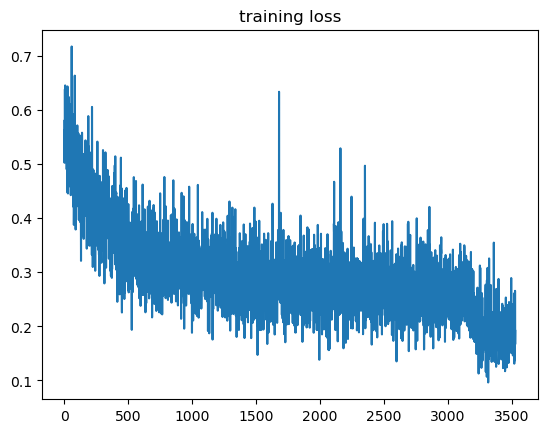

In [87]:
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        # train(model, epoch, log_interval)
        train(model, epoch, log_interval, train_loader, device, optimizer, transform, dir)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")

## On sauvegarde le modèle, ne pas oublier de le charger la prochaine fois

In [88]:
torch.save(model.state_dict(), 'modelMFCCNoisySilenceSet90.pth')
print("Model saved.")

Model saved.


In [89]:
import torch.nn.functional as F

def pad_or_trim(tensor, target_length):
    if tensor.size(-1) < target_length:
        return F.pad(tensor, (0, target_length - tensor.size(-1)))
    else:
        return tensor[:, :target_length]


def predict(tensor):
    target_length = 16000  # Assurez-vous que toutes les entrées ont une longueur cohérente
    tensor = pad_or_trim(tensor, target_length)
    # print(f"Original tensor shape: {tensor.shape}")
    tensor = tensor.to(device)
    tensor = transform(tensor)
    # print(f"Shape after transform: {tensor.shape}")
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor
    

waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)
print(waveform, sample_rate, utterance)


waveform, sample_rate, utterance, *_ = test_set[931]
ipd.Audio(waveform.numpy(), rate=sample_rate)
print(f"data {40} : Expected: {utterance}. Predicted: {predict(waveform)}.")






tensor([[-0.0072, -0.0047,  0.0103,  ..., -0.1142, -0.0711, -0.0295]]) 16000 silence
data 40 : Expected: stop. Predicted: stop.


In [90]:
print(len(test_set))

y_test = []
predictions = []

i=0
k=0
for (waveform, sample_rate, utterance, *_) in (test_set):
    i+=1
    output = predict(waveform)
    y_test.append(utterance)
    predictions.append(output)
    if output != utterance:
        k+=1
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        #break
if (k==0):
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

print("Accuracy on test_set = ",((len(test_set)-k)/len(test_set))*100)


7900
Data point #2. Expected: right. Predicted: unknown.
Data point #4. Expected: right. Predicted: unknown.
Data point #5. Expected: right. Predicted: unknown.
Data point #9. Expected: right. Predicted: unknown.
Data point #10. Expected: right. Predicted: unknown.
Data point #11. Expected: right. Predicted: unknown.
Data point #12. Expected: right. Predicted: unknown.
Data point #16. Expected: right. Predicted: unknown.
Data point #17. Expected: right. Predicted: left.
Data point #18. Expected: right. Predicted: unknown.
Data point #19. Expected: right. Predicted: unknown.
Data point #21. Expected: right. Predicted: left.
Data point #28. Expected: right. Predicted: left.
Data point #33. Expected: right. Predicted: left.
Data point #35. Expected: right. Predicted: unknown.
Data point #43. Expected: right. Predicted: unknown.
Data point #44. Expected: right. Predicted: unknown.
Data point #46. Expected: right. Predicted: unknown.
Data point #47. Expected: right. Predicted: left.
Data po

## CONFUSION MATRIX

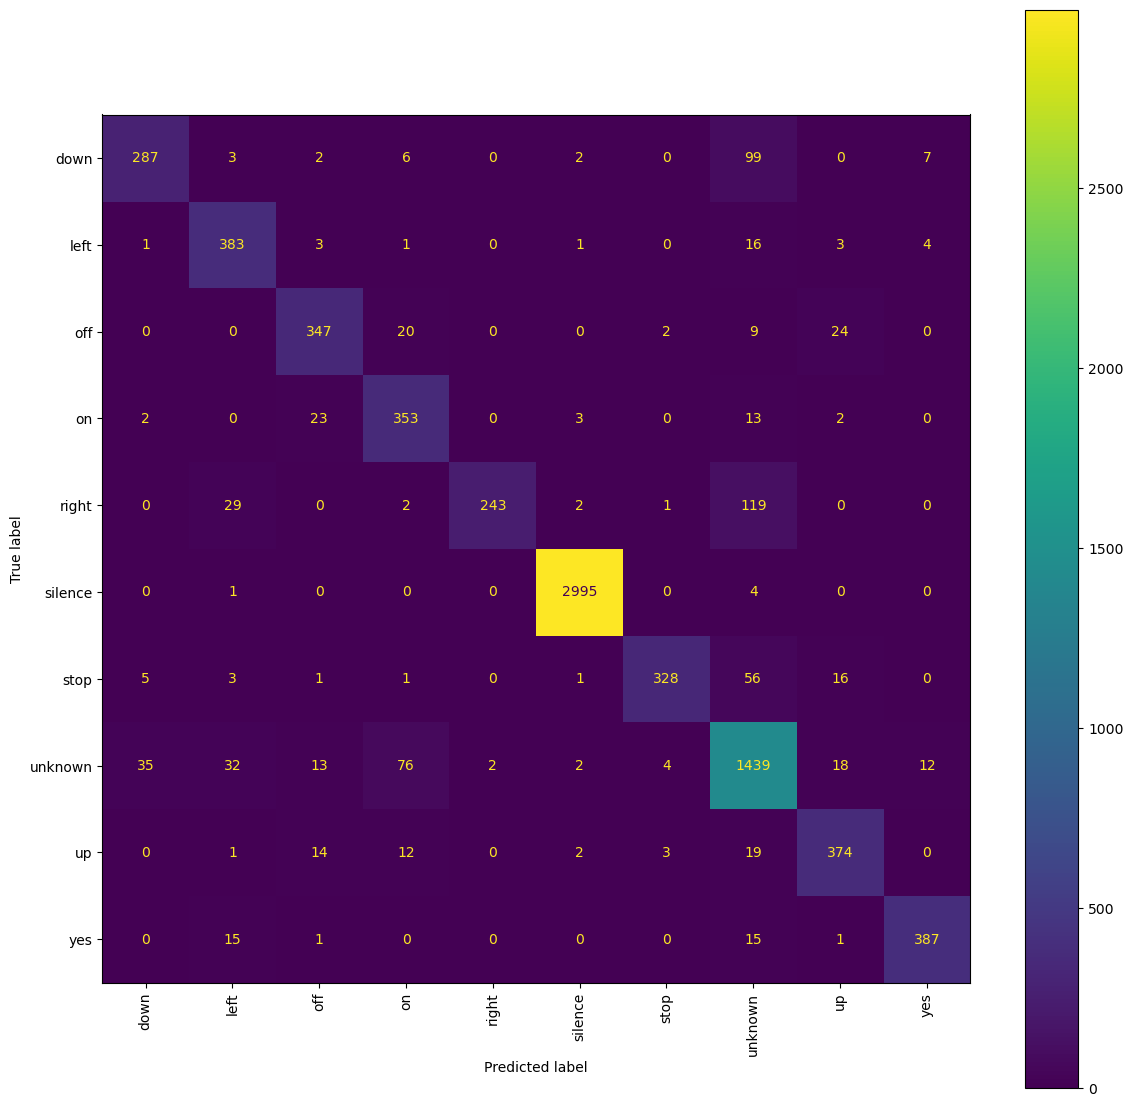

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Générer la matrice de confusion
cm = confusion_matrix(y_test, predictions)

# Créer une figure de taille personnalisée
fig, ax = plt.subplots(figsize=(14, 14))  # Ajustez les dimensions selon vos besoins



# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical')  # Rotation des labels de l'axe des x pour une meilleure lisibilité


# Afficher la figure
plt.show()


## Tests in real conditions

In [92]:

print(len(test_set))
y_test_noisy = []
predictions_noisy = []

i = 0
k = 0

# Chemin vers le répertoire contenant les fichiers de bruit
background_noise_dir = 'C:/Users/rirou/stage2a/SpeechCommandsRAW/SpeechCommands/speech_commands_v0.02/_background_noise_/'

# Obtenir la liste des fichiers .wav dans le répertoire
noise_files = [f for f in os.listdir(background_noise_dir) if f.endswith('.wav')]

for (waveform, sample_rate, utterance, *_) in test_set:
    i += 1
    
    # Skip adding noise if the utterance is "silence"
    if utterance == 'silence':
        y_test_noisy.append(utterance)
        output = predict(waveform)
        predictions_noisy.append(output)
        if output != utterance:
            k += 1
            print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        continue

    # Sélectionner aléatoirement un fichier de bruit
    selected_noise_file = random.choice(noise_files)

    # Charger l'échantillon de bruit sélectionné
    noise_waveform, noise_sample_rate = torchaudio.load(os.path.join(background_noise_dir, selected_noise_file))

    # Normaliser les échantillons de bruit
    noise_waveform = noise_waveform / torch.max(torch.abs(noise_waveform))

    # Définir l'amplitude aléatoire pour le bruit
    noise_amplitude = random.uniform(0.1, 0.5)

    # Ajuster le bruit à la longueur de l'échantillon de parole
    noise_length = waveform.size(1)
    if noise_waveform.size(1) > noise_length:
        # Cadrage aléatoire du bruit
        start = random.randint(0, noise_waveform.size(1) - noise_length)
        noise_waveform = noise_waveform[:, start:start + noise_length]
    else:
        # Répéter le bruit s'il est trop court
        repeats = (noise_length // noise_waveform.size(1)) + 1
        noise_waveform = noise_waveform.repeat(1, repeats)[:, :noise_length]

    # Appliquer l'amplitude au bruit
    noise_waveform = noise_waveform * noise_amplitude

    # Ajouter le bruit à l'échantillon de parole
    noisy_speech_waveform = waveform + noise_waveform

    # Normaliser l'échantillon bruyant
    noisy_speech_waveform = noisy_speech_waveform / torch.max(torch.abs(noisy_speech_waveform))

    output = predict(noisy_speech_waveform)
    y_test_noisy.append(utterance)
    predictions_noisy.append(output)
    if output != utterance:
        k += 1
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        # break

if k == 0:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

print("Score on noisy test_set = ", (len(test_set) - k) / len(test_set) * 100)

7900
Data point #2. Expected: right. Predicted: unknown.
Data point #5. Expected: right. Predicted: unknown.
Data point #10. Expected: right. Predicted: unknown.
Data point #12. Expected: right. Predicted: unknown.
Data point #17. Expected: right. Predicted: unknown.
Data point #19. Expected: right. Predicted: unknown.
Data point #25. Expected: right. Predicted: unknown.
Data point #27. Expected: right. Predicted: unknown.
Data point #33. Expected: right. Predicted: left.
Data point #34. Expected: right. Predicted: unknown.
Data point #35. Expected: right. Predicted: unknown.
Data point #40. Expected: right. Predicted: unknown.
Data point #41. Expected: right. Predicted: unknown.
Data point #46. Expected: right. Predicted: unknown.
Data point #47. Expected: right. Predicted: unknown.
Data point #52. Expected: right. Predicted: unknown.
Data point #57. Expected: right. Predicted: unknown.
Data point #60. Expected: right. Predicted: unknown.
Data point #62. Expected: right. Predicted: un

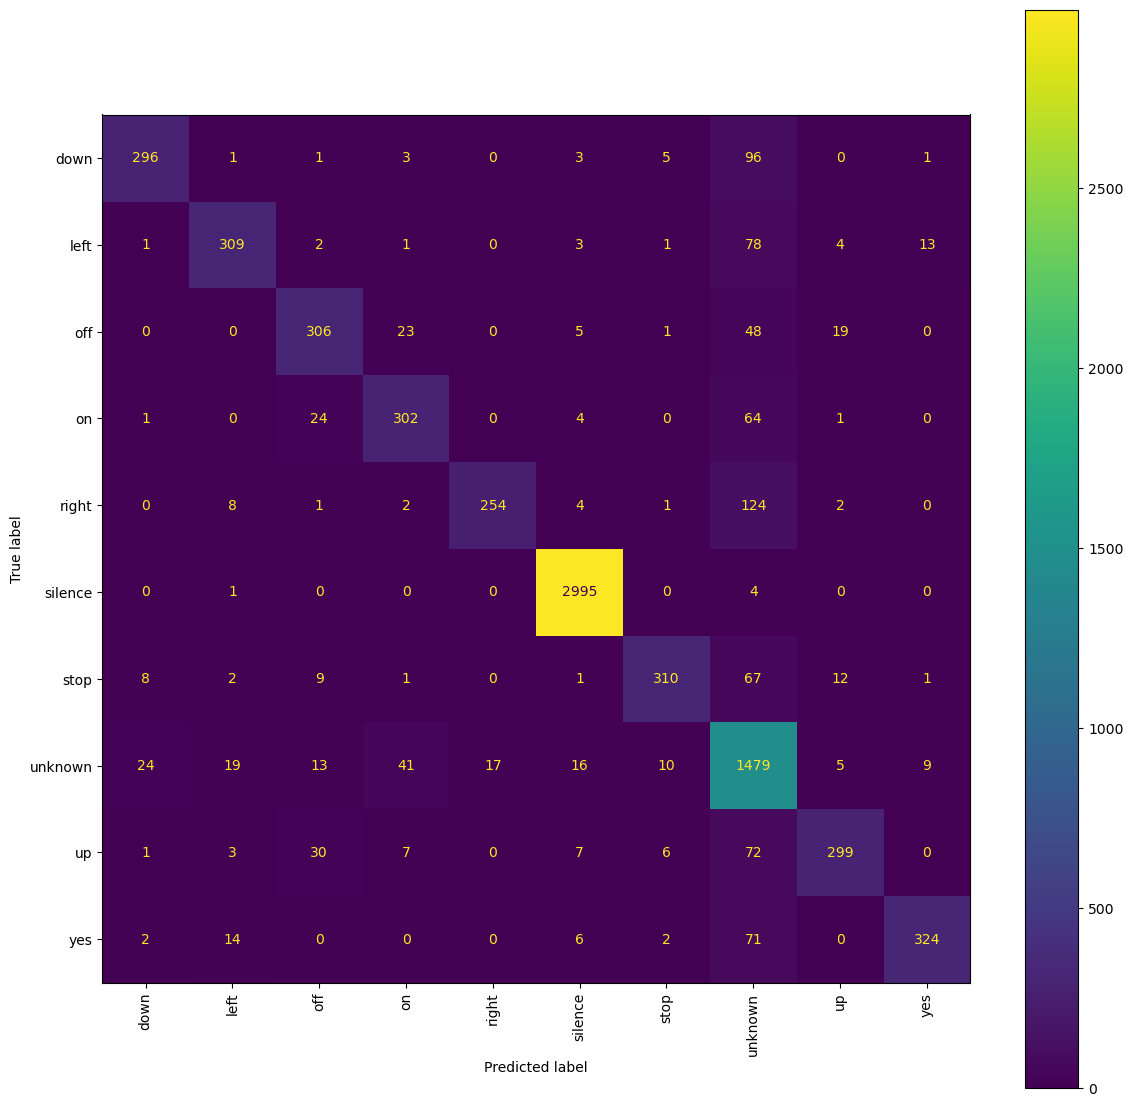

In [93]:
# Générer la matrice de confusion
cm_noisy = confusion_matrix(y_test_noisy, predictions_noisy)

# Créer une figure de taille personnalisée
fig_n, ax_n = plt.subplots(figsize=(14, 14))  # Ajustez les dimensions selon vos besoins



# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm_noisy, display_labels=labels)
disp.plot(ax=ax_n, xticks_rotation='vertical')  # Rotation des labels de l'axe des x pour une meilleure lisibilité


# Afficher la figure
plt.show()

In [103]:
from pvrecorder import PvRecorder
import numpy as np 

def preprocess_audio(audio_data, sample_rate=16000):
    # Convertir en tensor
    waveform = torch.tensor(audio_data, dtype=torch.float32)
    waveform = waveform / 32768.0  # Normaliser
    return waveform


recorder = None
i = 0
frame_length = 16000 // 1  # Taille du pas (0.1 seconde à une fréquence d'échantillonnage de 16000 Hz)
window_size = 16000  # Taille de la fenêtre (1 seconde à une fréquence d'échantillonnage de 16000 Hz)

audio_buffer = np.zeros(window_size, dtype=np.int16)

try:
    recorder = PvRecorder(frame_length=frame_length, device_index=1)
    recorder.start()
    print('[Listening ...]')

    while True:
        i += 1
        pcm = recorder.read()
        audio_buffer = np.roll(audio_buffer, -frame_length)
        audio_buffer[-frame_length:] = pcm
        pcm2 = preprocess_audio(audio_buffer.tolist())

        if pcm2.dim() == 1:
            pcm2 = pcm2.unsqueeze(0)

        output = predict(pcm2)
        print(f"Data point #{i} predicted: {output}.")

except KeyboardInterrupt:
    sys.stdout.write('\b' * 2)
    print('Stopping ...')

finally:
    if recorder is not None:
        recorder.delete()
        print('Recorder deleted.')


[Listening ...]
Data point #1 predicted: up.
Data point #2 predicted: silence.
Data point #3 predicted: silence.
Data point #4 predicted: silence.
Data point #5 predicted: unknown.
Data point #6 predicted: silence.
Data point #7 predicted: silence.
Data point #8 predicted: unknown.
Data point #9 predicted: up.
Data point #10 predicted: silence.
Data point #11 predicted: silence.
Data point #12 predicted: silence.
Data point #13 predicted: silence.
Data point #14 predicted: left.
Data point #15 predicted: silence.
Data point #16 predicted: unknown.
Data point #17 predicted: silence.
Data point #18 predicted: right.
Data point #19 predicted: silence.
Data point #20 predicted: left.
Data point #21 predicted: left.
Data point #22 predicted: unknown.
Data point #23 predicted: silence.
Data point #24 predicted: left.
Data point #25 predicted: silence.
Data point #26 predicted: silence.
Data point #27 predicted: silence.
Data point #28 predicted: silence.
Data point #29 predicted: left.
Data 